In [139]:
from neuron import h
h.load_file('stdrun.hoc')
import numpy as np
import matplotlib.pyplot as plt
from stellate import Stellate
h.celsius = 37.0
h.steps_per_ms = 40
h.dt = 0.025
h.cvode_active(0)

0.0

In [281]:
stellate_0 = Stellate(0)
stell_theta_ic = h.IClamp(stellate_0.soma(0.5))
stellate_noise_ic = h.IClamp(stellate_0.soma(0.5))
stellate_noise_ic.dur = 1e9
stell_theta_ic.dur = 1e9

time_dur = 8000  # ms

mean, std = -3e-3, 3e-4
time_steps = int(time_dur / h.dt)

noise_arr = np.random.normal(0, std, time_steps)

half = time_steps // 2

# baseline inhibition
noise_arr[:half] += mean

delta = 1e-3   
noise_arr[half:] += mean + delta

noise_vec = h.Vector(noise_arr)
noise_vec.play(stellate_noise_ic._ref_amp, h.dt)  
#stellate_noise_ic.amp = -5e-3
theta_amp = 0.5e-4
theta_freq = 10.0
theta_arr = theta_amp * np.sin(2 * np.pi * theta_freq * np.arange(0, time_dur, h.dt) / 1000)
theta_dupe = theta_arr.copy()
#theta_arr[half:] = 0.0
theta_vec = h.Vector(theta_arr)
theta_vec.play(stell_theta_ic._ref_amp, h.dt)

nc_stell = h.NetCon(stellate_0.soma(0.5)._ref_v, None, sec=stellate_0.soma)
nc_stell.threshold = 0
spike_times_stell = h.Vector()
nc_stell.record(spike_times_stell)

stell_v = h.Vector().record(stellate_0.soma(0.5)._ref_v)
stellate_gh_vec = h.Vector().record(stellate_0.soma(0.5).stellate_mech._ref_gh)
noise_input = h.Vector().record(stellate_noise_ic._ref_amp)
theta_input = h.Vector().record(stell_theta_ic._ref_amp)
stellate_gh_vec = h.Vector().record(stellate_0.soma(0.5).stellate_mech._ref_gh)
time = h.Vector().record(h._ref_t)



In [282]:
h.finitialize(-65)
h.continuerun(time_dur)



0.0

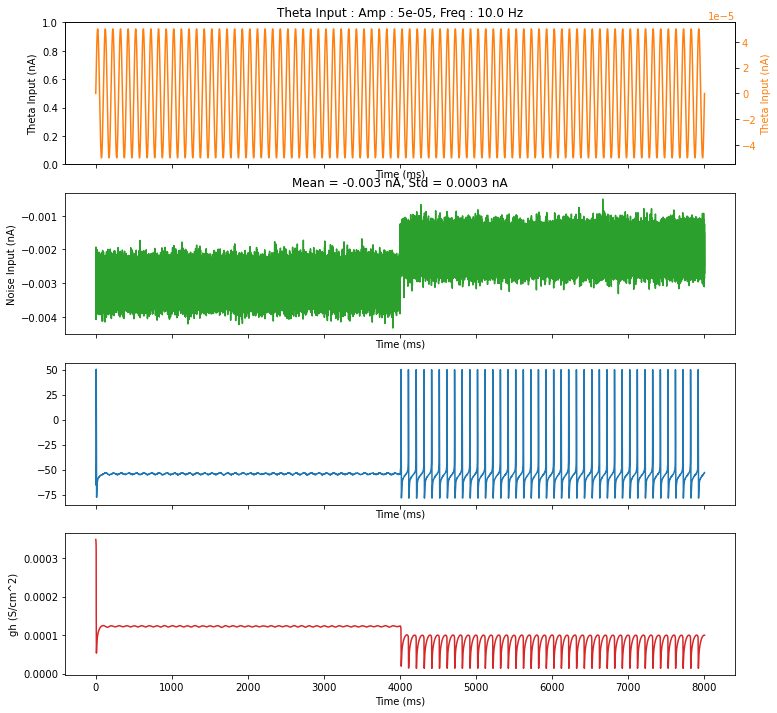

In [283]:

fig,ax = plt.subplots(4,1,figsize=(12, 12), sharex=True)
ax1 = ax[0].twinx()
ax1.plot(time, theta_input.to_python(), color='C1', label='Theta Input')
ax1.set_ylabel("Theta Input (nA)", color='C1')
ax1.tick_params(axis='y', labelcolor='C1')
#plt.plot(time,noise_input.to_python())
ax[2].plot(time, stell_v.to_python())
ax[0].set_xlabel("Time (ms)")
ax[2].set_xlabel("Time (ms)")
ax[1].set_xlabel("Time (ms)")
ax[0].set_ylabel("Theta Input (nA)")
ax[1].set_ylabel("Noise Input (nA)")
ax[0].set_title(f"Theta Input : Amp : {theta_amp}, Freq : {theta_freq:.1f} Hz")
ax[1].set_title(f"Mean = {mean} nA, Std = {std} nA")
ax[1].plot(time,noise_input.to_python(), color='C2', label='Noise Input')
ax[3].plot(time, stellate_gh_vec.to_python(), color='C3', label='gh')
ax[3].set_xlabel("Time (ms)")
ax[3].set_ylabel("gh (S/cm^2)")
#ax[2].set_ylim(-60,-50)

plt.show()

In [284]:
spike_times_array = spike_times_stell.to_python()
print("Spike times (ms):", spike_times_array)
print("Interspike intervals (ms):", np.diff(spike_times_array))

Spike times (ms): [5.475000000100044, 4011.324999976789, 4108.549999975375, 4210.949999973885, 4313.799999972388, 4413.674999970935, 4514.32499996947, 4615.5749999679965, 4715.399999966544, 4814.899999965096, 4916.174999963622, 5016.574999962161, 5116.4749999607075, 5217.0749999592435, 5317.374999957784, 5418.724999956309, 5518.499999954857, 5618.6499999534, 5717.774999951957, 5817.299999950509, 5917.774999949047, 6017.5249999475955, 6115.924999946164, 6214.7499999447255, 6316.274999943248, 6417.474999941775, 6519.099999940297, 6617.699999938862, 6718.299999937398, 6817.199999935959, 6916.599999934512, 7016.949999933052, 7116.7249999316, 7218.274999930122, 7318.674999928661, 7419.599999927193, 7519.42499992574, 7617.774999924309, 7716.724999922869, 7816.749999921413, 7916.424999919963]
Interspike intervals (ms): [4005.84999998   97.225       102.4         102.85         99.875
  100.65        101.25         99.825        99.5         101.275
  100.4          99.9         100.6         

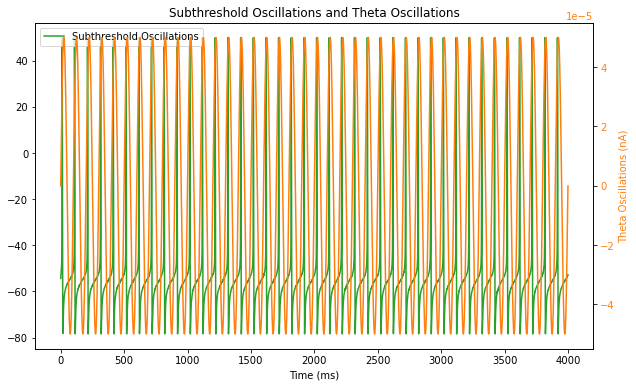

In [285]:
#subthreshold oscillations and theta oscillations
smpos_arr = stell_v.to_python()[half+1:]
theta_osc_arr = theta_dupe[half:]
fig,ax = plt.subplots(figsize=(10, 6))
ax1 = ax.twinx()
ax1.plot(time.to_python()[:half], theta_osc_arr, color='C1', label='Theta Oscillations')
ax1.set_ylabel("Theta Oscillations (nA)", color='C1')
ax1.tick_params(axis='y', labelcolor='C1')
ax.plot(time.to_python()[:half], smpos_arr, color='C2', label='Subthreshold Oscillations')
ax.set_xlabel("Time (ms)")
ax.set_title("Subthreshold Oscillations and Theta Oscillations")
ax.legend(loc='upper left')

plt.show()

Spike phases (radians): [0.3440044  0.71157073 0.53721234 0.68800879 0.86707957 0.85922559
 0.90006629 0.97860611 0.96761054 0.93619461 1.01630522 1.04143796
 1.03515478 1.07285389 1.09170344 1.17652645 1.16238928 1.17181406
 1.11683619 1.08699106 1.11683619 1.10112822 1.00059726 0.92676983
 1.02258841 1.09798663 1.20008839 1.1121238  1.14982291 1.08070787
 1.04300876 1.06499991 1.05086274 1.14825211 1.17338485 1.23150432
 1.22050874 1.11683618 1.05086274 1.05243353 1.03201318]


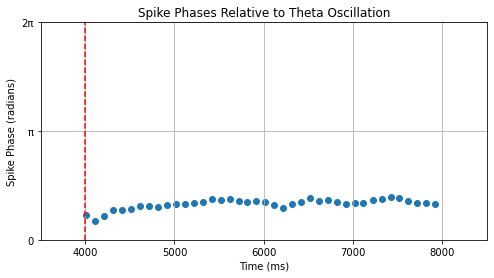

In [286]:
#spikes to phases
phases = (np.array(spike_times_array) * theta_freq * 2 * np.pi / 1000) % (2 * np.pi)
print("Spike phases (radians):", phases)

plt.figure(figsize=(8, 4))
plt.scatter(spike_times_array, phases, color='C0')
plt.xlabel("Time (ms)")
plt.ylabel("Spike Phase (radians)")
plt.title("Spike Phases Relative to Theta Oscillation")
plt.yticks([0, np.pi, 2 * np.pi], ['0', 'π', '2π'])
plt.xlim(3500, time_dur+500)
plt.axvline(x=half*h.dt, color='r', linestyle='--', label='Disinhibition')
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


320001


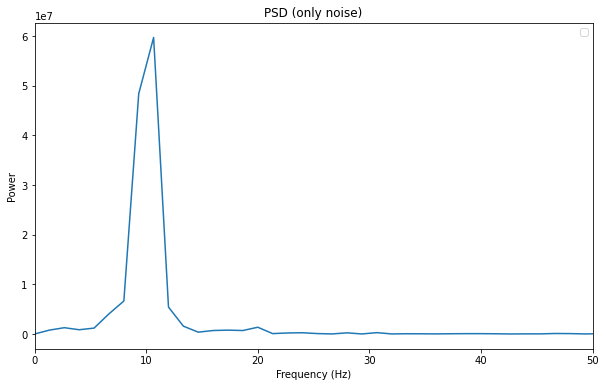

In [287]:
import analysis_utils as a_utils
print(len(stell_v.to_python()))
fft_freq,fft_sig,fft_power = a_utils.calc_fft(stell_v.to_python()[10000:40000])
plt.figure(figsize=(10, 6))
plt.plot(fft_freq, fft_power)
plt.xlim(0, 350)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
#plt.axvline(x=1000/37.1, color='r', linestyle='--', label=f'Dominant Frequency: {1000/62.2:.2f} Hz  ')
#plt.axvline(x=theta_freq, color='r', linestyle='--')
plt.xlim(0,1000)
plt.title("PSD (only noise)")
plt.legend()
plt.xlim(0,50)
plt.show()

Impedance Analysis

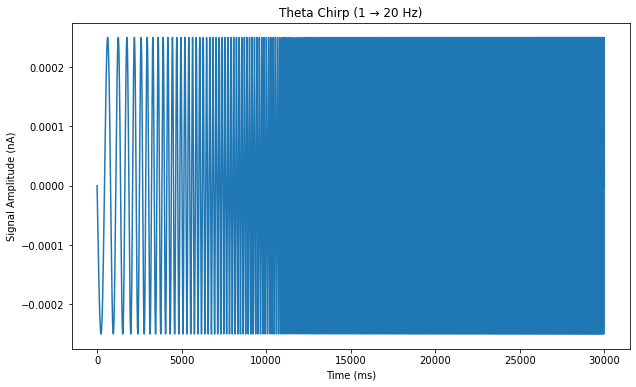

In [162]:
time_arr = np.arange(0, 30000, h.dt)  # ms
t_sec = time_arr / 1000.0                # convert to seconds

min_freq = 1.0
max_freq = 20.0
theta_amp = -2.5e-3

k = (max_freq - min_freq) / (t_sec[-1])  # Hz per second

phase = 2 * np.pi * (min_freq * t_sec + 0.5 * k * t_sec**2)

signal_arr = theta_amp/10 * np.sin(phase)

plt.figure(figsize=(10,6))
plt.plot(time_arr, signal_arr)
plt.xlabel("Time (ms)")
plt.ylabel("Signal Amplitude (nA)")
plt.title("Theta Chirp (1 → 20 Hz)")
plt.show()

1200000


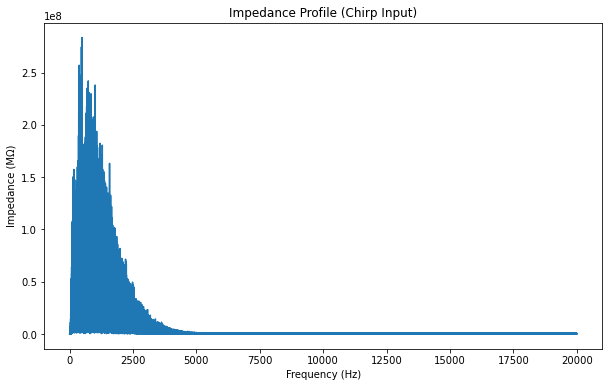

max  283537522.7494601
at 490.4997956250852
Q factor: 2550.585651801468


In [110]:
chirp_ic = h.IClamp(stellate_0.soma(0.5))
chirp_ic.dur = 1e9
chirp_vec = h.Vector(signal_arr)
chirp_vec.play(chirp_ic._ref_amp, h.dt)

imp_i = h.Vector().record(chirp_ic._ref_amp)
imp_v= h.Vector().record(stellate_0.soma(0.5)._ref_v)

time = h.Vector().record(h._ref_t)
h.finitialize(-55)
h.continuerun(time_dur*3)

i_mean = np.mean(imp_i.to_python())
imp_i_arr = imp_i.to_python() - i_mean
v_mean = np.mean(imp_v.to_python())
imp_v_arr = imp_v.to_python() - v_mean

volt_fft_freq, volt_fft_sig, volt_fft_power = a_utils.calc_fft(imp_v_arr)
curr_fft_freq, curr_fft_sig, curr_fft_power = a_utils.calc_fft(imp_i_arr)

print(len(curr_fft_freq))
impedance = np.abs(volt_fft_sig / curr_fft_sig)
plt.figure(figsize=(10, 6))
plt.plot(curr_fft_freq, impedance)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Impedance (MΩ)")
plt.title("Impedance Profile (Chirp Input)")   
     
plt.show()  


print("max ",np.max(impedance))
print("at", curr_fft_freq[np.argmax(impedance)])
print("Q factor:", np.max(impedance) / impedance[0])